In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_2_vs_4_binary_predictor"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = [ 2, 4 ]

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11776, 28, 28, 1)
n train samples = 11776
n test samples = 1984


In [3]:
#Make binary labels

digit_train = np.argmax(y_train, axis=-1)
digit_test = np.argmax(y_test, axis=-1)

y_train = np.zeros((digit_train.shape[0], 1))
y_train[digit_train == included_classes[0], 0] = 0
y_train[digit_train == included_classes[1], 0] = 1

y_test = np.zeros((digit_test.shape[0], 1))
y_test[digit_test == included_classes[0], 0] = 0
y_test[digit_test == included_classes[1], 0] = 1


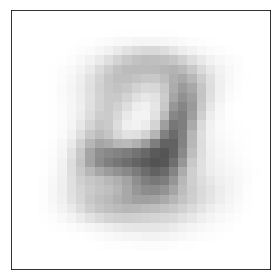

In [4]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [5]:
#Calculate mean training set conservation

entropy = (x_mean * -np.log(x_mean) + (1. - x_mean) * -np.log(1. - x_mean)) / np.log(2.0)
conservation = 1.0 - entropy

x_mean_conservation = np.mean(conservation)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.6241306924499999


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, :, :, 0]), 1e-8, 1. - 1e-8)

x_mean_broadcasted = np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))

kl_divs = (x_train_clipped * np.log(x_train_clipped / x_mean_broadcasted) + (1. - x_train_clipped) * np.log((1. - x_train_clipped) / (1. - x_mean_broadcasted))) / np.log(2.0)

x_mean_kl_divs = np.mean(kl_divs, axis=(1, 2))
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 0.3753392663167618


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/binary-stochastic-neurons-in-tensorflow.html
#See Github https://github.com/spitis/

def bernoulli_sample(x):
    g = tf.get_default_graph()
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]


In [8]:
#Masking and Sampling helper functions

def sample_image_st(x) :
    p = tf.sigmoid(x)

    return bernoulli_sample(p)

#Generator helper functions
def initialize_templates(generator, background_matrices) :

    embedding_backgrounds = []

    for k in range(len(background_matrices)) :
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=1) :

    #Initialize Reshape layer
    reshape_layer = Reshape((n_rows, n_cols, 1))
    
    #Initialize background matrix
    background_dense = Embedding(n_classes, n_rows * n_cols, embeddings_initializer='zeros', name='background_dense')

    #Initialize Templating and Masking Lambda layer
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize Sigmoid layer
    image_layer = Lambda(lambda x: K.sigmoid(x), name='image')
    
    #Initialize Sampling layers
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_image_st, name='image_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, n_rows, n_cols, 1)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        background = reshape_layer(background_dense(class_input))
        
        #Add Template and Multiply Mask
        image_logits = background_layer([raw_logits, background])
        
        #Compute Image (Sigmoids from logits)
        image = image_layer(image_logits)
        
        #Tile each image to sample from and create sample axis
        image_logits_upsampled = upsampling_layer(image_logits)
        sampled_image = sampling_layer(image_logits_upsampled)
        sampled_image = permute_layer(sampled_image)
        
        return image_logits, image, sampled_image
    
    return _sampler_func


In [9]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def mask_top_k(x, k=100) :

    #arr = K.reshape(x, (K.shape(x)[0], K.shape(x)[1] * K.shape(x)[2] * K.shape(x)[3]))
    arr = K.reshape(x, (batch_size, 28 * 28))

    values, indices = tf.nn.top_k(arr, k=k, sorted=False)

    temp_indices = tf.meshgrid(*[tf.range(d) for d in (tf.unstack(
           tf.shape(arr)[:(arr.get_shape().ndims - 1)]) + [k])], indexing='ij')
    temp_indices = tf.stack(temp_indices[:-1] + [indices], axis=-1)
    full_indices = tf.reshape(temp_indices, [-1, arr.get_shape().ndims])
    values = tf.reshape(values, [-1])

    mask_st = tf.SparseTensor(indices=tf.cast(
          full_indices, dtype=tf.int64), values=tf.ones_like(values), dense_shape=arr.shape)
    mask = tf.sparse_tensor_to_dense(tf.sparse_reorder(mask_st))

    x_masked = K.reshape(mask, (batch_size, 28, 28, 1))

    return x_masked

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0, delta_lum=0.05, n_max_unrolls=4, unroll_rates=[0.4, 0.3, 0.2, 0.1]) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    mask_concat = Concatenate(axis=-1)
    mask_add = Lambda(lambda x: (x[0] * (1. - x[1])) + (x[1] * 100.))
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='softplus', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    image_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_image_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] / K.maximum(x[0], K.epsilon()), name='scrambler_logit_scale')
    
    def _scrambler_func_helper(image_input, mask_input) :
        
        conv_0_out = conv_0(mask_concat([image_input, mask_input]))

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        final_conv_out = mask_add([final_conv_out, mask_input])
        
        return final_conv_out
    
    def _scrambler_func(image_input, mask_input) :
        
        mask_levels = [Lambda(lambda x: K.expand_dims(K.reshape(x, (batch_size, 28, 28, 1)), axis=1))(mask_input)]
        curr_mask = mask_input
        for unroll_ix in range(n_max_unrolls) :
            curr_importance_scores = Lambda(lambda x: K.stop_gradient(_scrambler_func_helper(x[0], x[1])))([image_input, curr_mask])
            
            curr_mask = Lambda(lambda x: mask_top_k(x, k=min(int((unroll_ix + 1) * delta_lum * 784), 784)))(curr_importance_scores)
            mask_levels.append(Lambda(lambda x: K.expand_dims(x, axis=1))(curr_mask))
        
        masks = Concatenate(axis=1)(mask_levels)
        sampled_mask_ind = Lambda(lambda x: tf.one_hot(tf.squeeze(tf.multinomial(K.tile(K.constant(np.array(unroll_rates).reshape(1, -1)), (batch_size, 1)), 1), 1), n_max_unrolls + 1, 1.0, 0.0))(masks)
        
        mask = Lambda(lambda x: K.sum(x[0] * K.reshape(x[1], (K.shape(x[1])[0], K.shape(x[1])[1], 1, 1, 1)), axis=1))([masks, sampled_mask_ind])
        
        mask_switched = Lambda(lambda x: K.switch(K.learning_phase(), x[0], x[1]))([mask, mask_input])
        
        importance_scores = _scrambler_func_helper(image_input, mask_switched)
        
        #Scale logits by importance scores
        scaled_logits = scale_logits([importance_scores, image_to_logits(image_input)])
        
        return scaled_logits, importance_scores, mask_switched

    return _scrambler_func


In [10]:
#Keras loss functions

def get_sigmoid_kl_divergence() :

    def _sigmoid_kl_divergence(y_true, y_pred) :

        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        
        mean_kl = K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
        
        return mean_kl
    
    return _sigmoid_kl_divergence

def get_margin_lum_ame_masked(max_lum=1.0) :
    
    def _margin_lum_ame(importance_scores, importance_mask) :
        
        mask = 1. - importance_mask[:, :, :, 0]
        n_unmasked = K.maximum(K.sum(mask, axis=(1, 2)), 1.)
        
        p_ons = 2. * K.sigmoid(importance_scores[..., 0]) - 1.
        
        mean_p_on = K.sum(p_ons * mask, axis=(1, 2)) / n_unmasked

        margin_p_on = K.switch(mean_p_on > K.constant(max_bits, shape=(1,)), mean_p_on - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_p_on))
    
        return margin_p_on
    
    return _margin_lum_ame

def get_target_lum_sme_masked(target_lum=1.0) :
    
    def _target_lum_sme(importance_scores, importance_mask) :
        
        mask = 1. - importance_mask[:, :, :, 0]
        n_unmasked = K.maximum(K.sum(mask, axis=(1, 2)), 1.)
        
        p_ons = 2. * K.sigmoid(importance_scores[..., 0]) - 1.
        
        mean_p_on = K.sum(p_ons * mask, axis=(1, 2)) / n_unmasked
        
        return (mean_p_on - target_lum)**2
    
    return _target_lum_sme

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [11]:
#Initialize Encoder and Decoder networks
batch_size = 32
n_rows = 28
n_cols = 28
n_samples = 32

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0
resnet_delta_lum = 0.05
resnet_n_max_unrolls = 4
resnet_unroll_rates = [0.25, 0.25, 0.2, 0.2, 0.1]

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate,
    delta_lum=resnet_delta_lum,
    n_max_unrolls=resnet_n_max_unrolls,
    unroll_rates=resnet_unroll_rates
)

#Load sampler
sampler = build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=n_samples)


In [12]:
#Load Predictor
predictor_path = 'saved_models/mnist_binarized_cnn_digit_2_vs_4.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [13]:
#Create inverted labels

y_train_inv = 1. - y_train
y_test_inv = 1. - y_test


In [14]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(n_rows, n_cols, 1), name='scrambler_input')
scrambler_mask = Input(shape=(n_rows, n_cols, 1), name='scrambler_mask')

scrambled_logits, importance_scores, _ = scrambler(scrambler_input, scrambler_mask)

image_logits, image, sampled_image = sampler(scrambler_class, scrambled_logits)

scrambler_model = Model([scrambler_input, scrambler_class, scrambler_mask], [image_logits, image, sampled_image, importance_scores])

#Initialize Templates and Masks
initialize_templates(scrambler_model, [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [15]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(n_rows, n_cols, 1), name='ae_scrambler_input')
ae_scrambler_mask = Input(shape=(n_rows, n_cols, 1), name='ae_scrambler_mask')
ae_label_input = Input(shape=(1,), name='ae_label_input')

scrambled_logits, importance_scores, importance_mask = scrambler(ae_scrambler_input, ae_scrambler_mask)

#Run encoder and decoder
_, scrambled_image, scrambled_sample = sampler(ae_scrambler_class, scrambled_logits)

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, n_rows, n_cols, 1)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled_deflated = ae_label_input#predictor([ae_scrambler_input])

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = predictor([scrambled_sample_deflated])

#Define layer to inflate sample axis
inflate_non_scrambled_prediction = Lambda(lambda x: K.tile(x, (1, n_samples)), name='inflate_non_scrambled_prediction')
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_non_scrambled = inflate_non_scrambled_prediction(y_pred_non_scrambled_deflated)
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#Cost function parameters
initial_target_lum = resnet_delta_lum
target_lum = resnet_delta_lum

#NLL cost
nll_loss_func = get_sigmoid_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_lum_sme_masked(target_lum=initial_target_lum)

#Entropy cost
entropy_loss_func = get_target_lum_sme_masked(target_lum=target_lum)
#entropy_loss_func = get_margin_lum_ame_masked(max_lum=target_lum)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1]), name='nll')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([importance_scores, importance_mask])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([importance_scores, importance_mask])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, ae_scrambler_mask, ae_label_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Templates and Masks
initialize_templates(loss_model, [x_mean_logits])

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=500.0)
    }
)


In [16]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_mask (InputLayer)     (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 28, 28, 1)    0           scrambler_input[0][0]            
                                                                 scrambler_mask[0][0]             
__________________________________________________________________________________________________
lambda_44 (Lambda)              (32, 28, 28, 1)      0           lambda_43[0][0]                  
__________

In [17]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ae_scrambler_mask (InputLayer)  (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
lambda_59 (Lambda)              (None, 28, 28, 1)    0           ae_scrambler_input[0][0]         
                                                                 ae_scrambler_mask[0][0]          
__________________________________________________________________________________________________
lambda_60 (Lambda)              (32, 28, 28, 1)      0           lambda_59[0][0]                  
__________

In [18]:
#Training configuration

#Define number of training epochs
n_epochs = 20

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_feature_aware_template_drop_ladder"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_lum_" + str(target_lum).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_target_lum_005_kl_divergence_feature_aware_template_drop_ladder


In [21]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

all_zeros_mask_train = np.zeros((x_train.shape[0], 28, 28, 1))
all_zeros_mask_test = np.zeros((x_test.shape[0], 28, 28, 1))

# train the autoencoder
train_history = loss_model.fit(
    [s_train, x_train, all_zeros_mask_train, y_train_inv],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test, all_zeros_mask_test, y_test_inv],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 11776 samples, validate on 1984 samples
Epoch 1/20
11776/11776 [==============================] - 202s 17ms/step - loss: 2.6782 - nll_loss: 2.5939 - conservation_loss: 0.0843 - entropy_loss: 0.0000e+00 - val_loss: 1.6026 - val_nll_loss: 1.5095 - val_conservation_loss: 0.0931 - val_entropy_loss: 0.0000e+00
Epoch 2/20
11776/11776 [==============================] - 157s 13ms/step - loss: 3.4310 - nll_loss: 2.7489 - conservation_loss: 0.0000e+00 - entropy_loss: 0.6820 - val_loss: 5.0853 - val_nll_loss: 3.9387 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.1466
Epoch 3/20
11776/11776 [==============================] - 157s 13ms/step - loss: 2.5578 - nll_loss: 2.1079 - conservation_loss: 0.0000e+00 - entropy_loss: 0.4499 - val_loss: 4.3326 - val_nll_loss: 2.8264 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 1.5062
Epoch 4/20
11776/11776 [==============================] - 158s 13ms/step - loss: 2.2406 - nll_loss: 1.8121 - conservation_loss: 0.0000e+00 - entropy_l

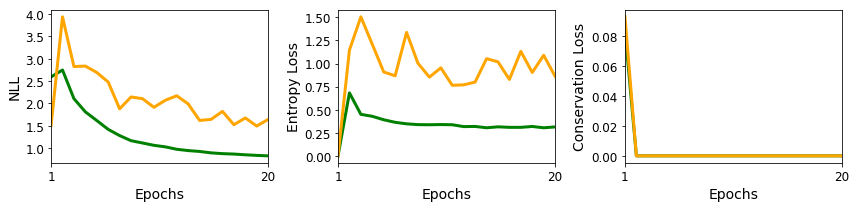

In [22]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [23]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_target_lum_005_kl_divergence_feature_aware_template_drop_ladder.h5 


In [19]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model.load_weights(model_path)

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_mnist_2_vs_4_binary_predictor_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_20_target_lum_005_kl_divergence_feature_aware_template_drop_ladder.h5 


Test image 0:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.35, 0.4, 0.02, 0.04, 0.01, 0.04, 0.02, 0.36, 0.29, 0.54]


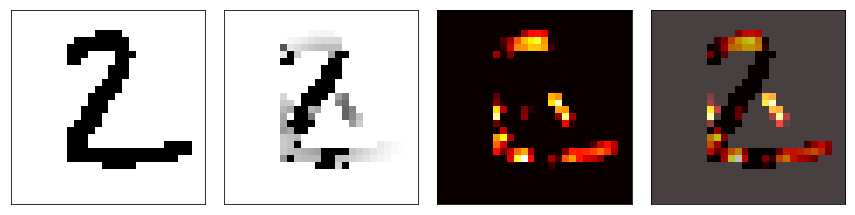

Test image 1:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.01, 0.06, 0.0, 0.0, 0.01, 0.15]


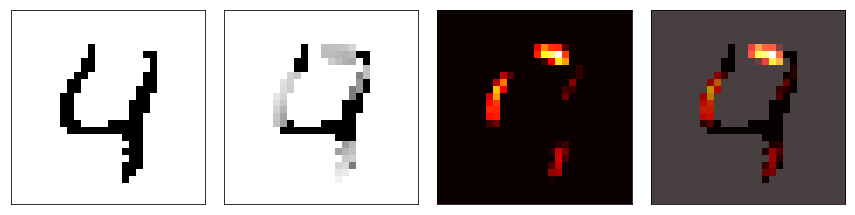

Test image 2:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.0, 0.27, 0.01, 0.02, 0.33, 0.0, 0.0, 0.03, 0.01]


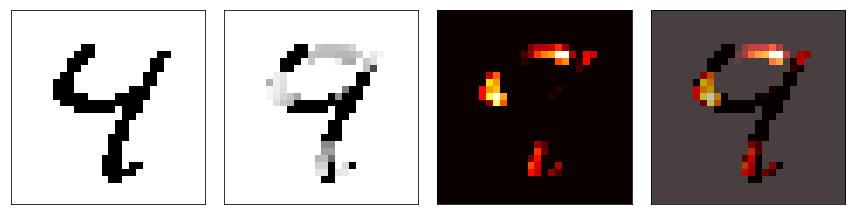

Test image 3:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.03, 0.0, 0.0]


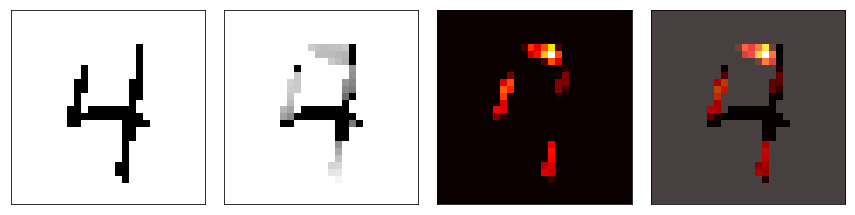

Test image 4:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.03]


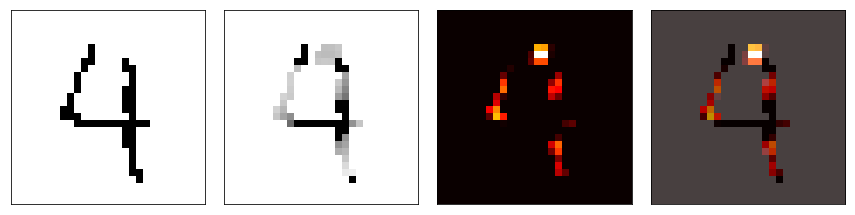

Test image 5:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]


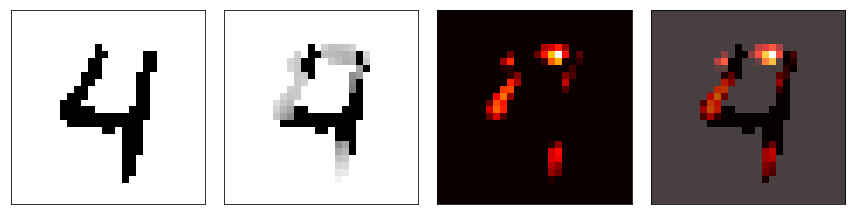

Test image 6:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.01, 0.0, 0.01, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02]


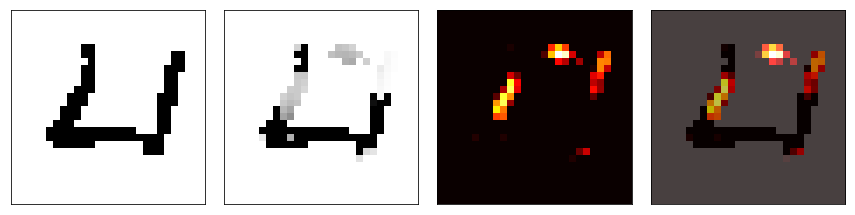

Test image 7:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.01, 0.03, 0.06, 0.17, 0.05, 0.96, 0.63, 0.12, 0.02, 0.0]


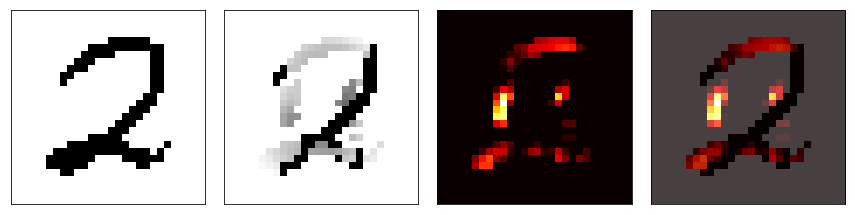

Test image 8:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.0, 0.9, 0.05, 0.97, 0.01, 0.05, 0.68, 0.05, 0.0, 0.0]


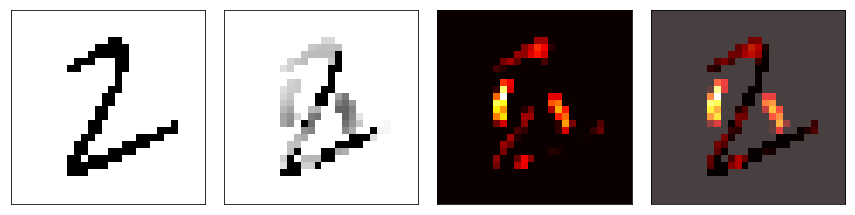

Test image 9:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.3, 0.91, 0.0, 0.84, 0.0, 1.0, 0.01, 0.0, 0.02]


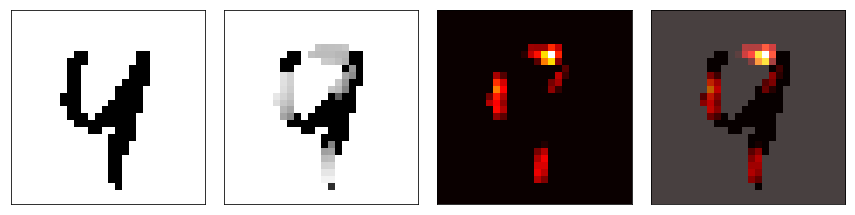

Test image 10:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.01, 0.02, 0.82, 0.98, 0.93, 0.53, 0.99, 0.99, 0.91, 0.99]


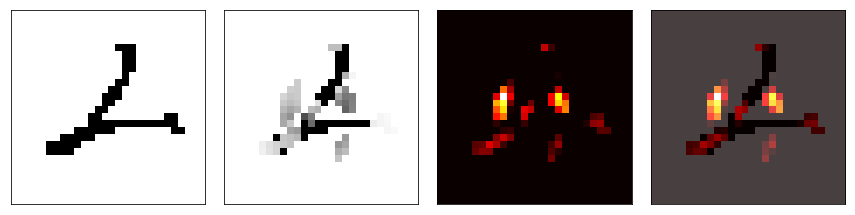

Test image 11:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.01, 0.01, 0.16, 0.39, 1.0, 0.92, 0.58, 0.69, 0.63, 0.26]


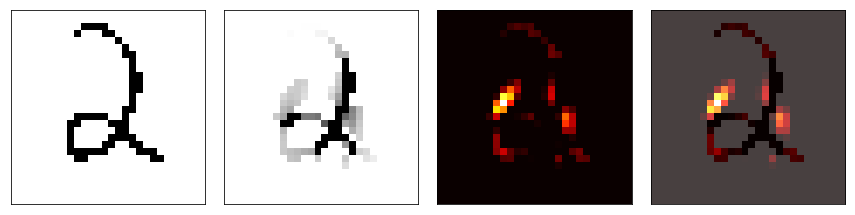

Test image 12:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.95, 0.13, 0.15, 0.02, 0.71, 0.66, 0.02, 0.38, 0.09, 0.53]


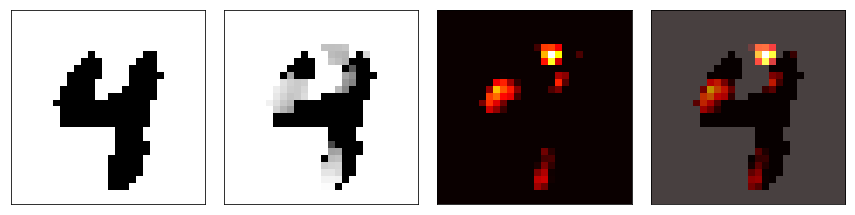

Test image 13:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.04, 0.0, 0.0, 0.0, 0.01, 0.06, 0.01, 0.01, 0.01, 0.0]


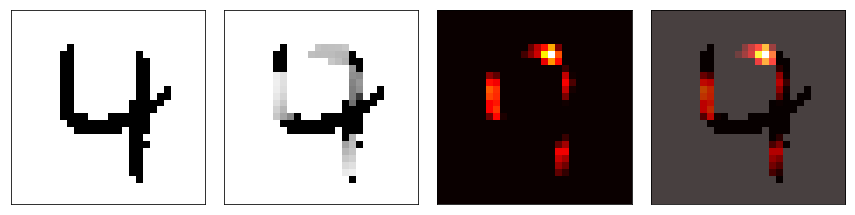

Test image 14:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.02, 0.0, 0.0, 0.29, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


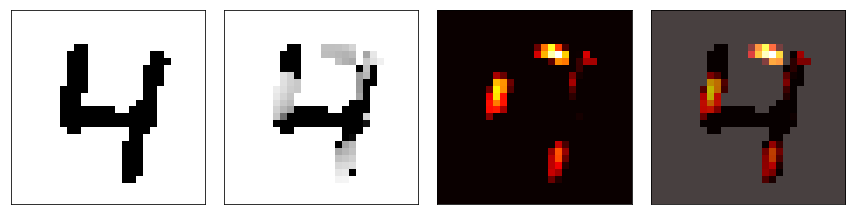

Test image 15:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.85, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01]


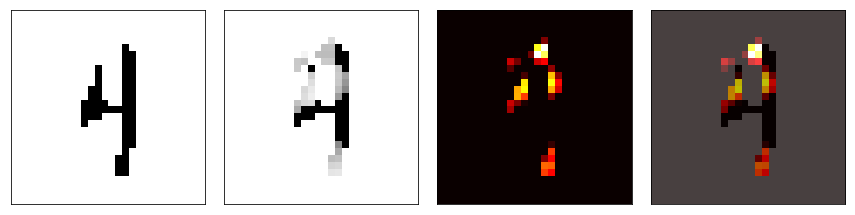

Test image 16:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.47, 0.0, 0.01]


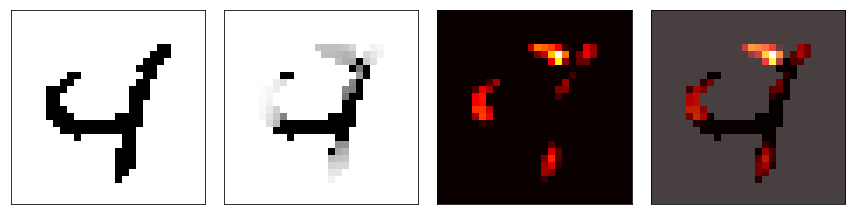

Test image 17:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.48, 0.0, 0.01, 0.12, 0.03, 0.05, 0.25, 0.03, 0.18, 0.0]


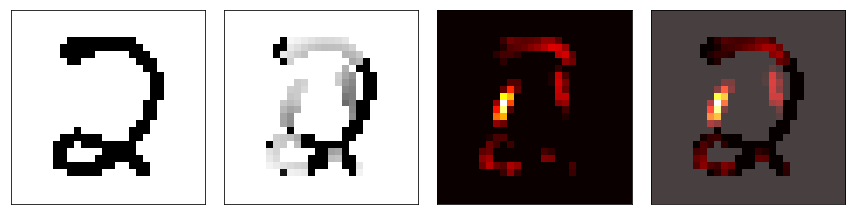

Test image 18:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [1.0, 0.96, 0.14, 1.0, 0.95, 0.97, 1.0, 0.5, 0.62, 0.18]


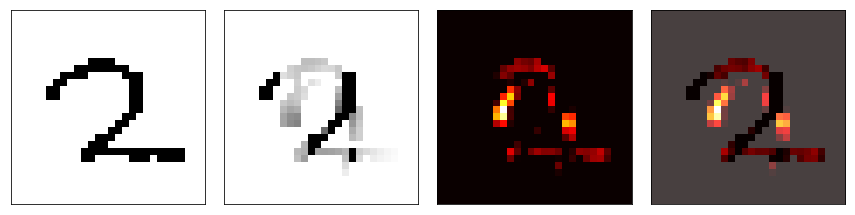

Test image 19:
 - Prediction (original) = 0.0
 - Predictions (scrambled) = [0.01, 0.02, 0.02, 0.0, 0.0, 0.12, 0.0, 0.01, 0.0, 0.0]


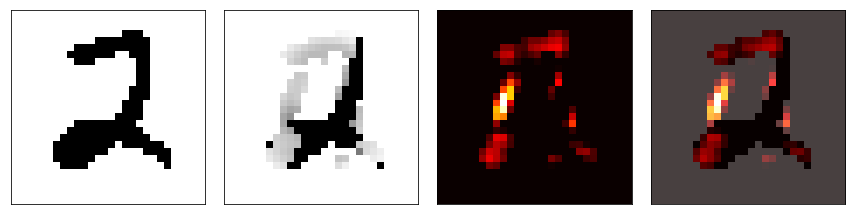

In [24]:
#Visualize a few reconstructed images

from numpy.ma import masked_array

s_test = np.zeros((x_test.shape[0], 1))

drop_mask = np.zeros((x_test.shape[0], 28, 28, 1))

_, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[x_test[:32], s_test[:32], drop_mask[:32]])

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[plot_i], axis=0)], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_test[plot_i]], batch_size=32)[:10, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


Test image 0:
 - Prediction (original) = 0.0
Depth = 0
 - Predictions (scrambled) = [0.01, 0.25, 0.35, 0.01, 0.02, 0.07, 0.27, 0.0, 0.97, 0.31]


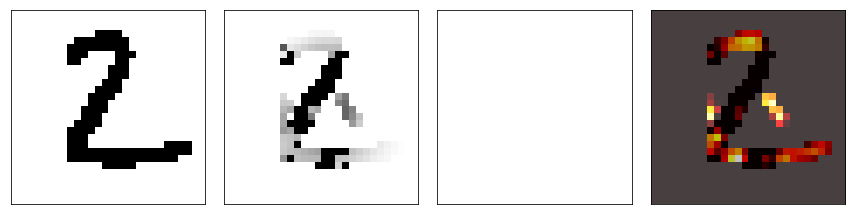

Max Luminescence (logit) = 185.65164
Total Luminescence (logit) = 5866.831
Mean Luminescence (logit) = 7.483203
Mean P(On) = 0.10509377
Depth = 1
 - Predictions (scrambled) = [0.97, 0.08, 0.89, 1.0, 0.65, 0.99, 0.66, 0.24, 0.99, 0.01]


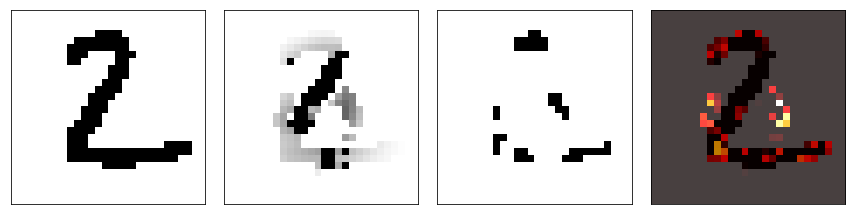

Max Luminescence (logit) = 169.59442
Total Luminescence (logit) = 7059.6436
Mean Luminescence (logit) = 9.004647
Mean P(On) = 0.12804464
Depth = 2
 - Predictions (scrambled) = [0.03, 0.12, 0.87, 0.56, 1.0, 1.0, 0.93, 0.99, 1.0, 0.99]


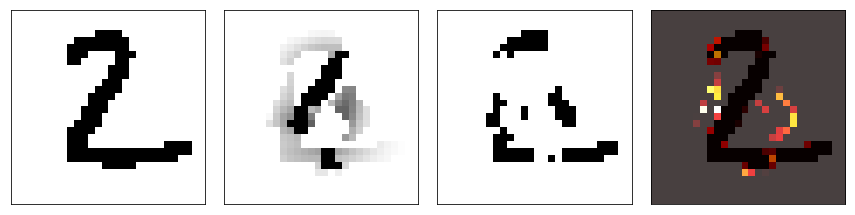

Max Luminescence (logit) = 126.79469
Total Luminescence (logit) = 9820.596
Mean Luminescence (logit) = 12.52627
Mean P(On) = 0.1558999
Depth = 3
 - Predictions (scrambled) = [0.94, 0.77, 1.0, 0.95, 1.0, 1.0, 1.0, 0.99, 0.9, 0.95]


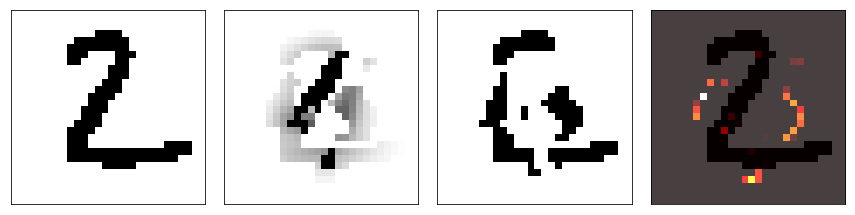

Max Luminescence (logit) = 172.01114
Total Luminescence (logit) = 13375.72
Mean Luminescence (logit) = 17.060867
Mean P(On) = 0.18725969


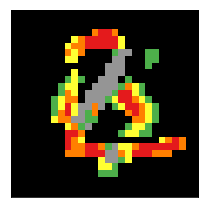

In [25]:
#Predict on test set

from numpy.ma import masked_array

save_figs = True

s_test = np.zeros((x_test.shape[0], 1))

test_ix = 0

n_levels = 4

drop_mask = np.zeros((batch_size, 28, 28, 1))

importance_score_qt_levels = [
    0.95,
    0.9,
    0.85,
    0.80
]

print("Test image " + str(test_ix) + ":")
    
y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[test_ix], axis=0)], batch_size=1)[0, 0]

print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])

importance_scores_levels = []
y_test_hat_levels = []

for level_ix in range(n_levels) :
    
    print("Depth = " + str(level_ix))
    
    _, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[np.tile(np.expand_dims(x_test[test_ix], axis=0), (batch_size, 1, 1, 1)), np.tile(np.expand_dims(s_test[test_ix], axis=0), (batch_size, 1)), drop_mask])

    y_test_hat = predictor.predict(x=[sample_test[0]], batch_size=32)[:, 0].tolist()
    
    y_test_hat_levels.append(y_test_hat)
    
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat[:10]))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    #ax3.imshow(importance_scores_test[0, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')
    ax3.imshow(drop_mask[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')
    
    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    importance_scores_delta = np.copy(importance_scores_test)
    
    importance_scores_delta[drop_mask == 1] = 0.
    
    ax4.imshow(importance_scores_delta[0, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_delta[0, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".eps")
    
    plt.show()
    
    importance_thresh = np.quantile(np.ravel(importance_scores_test[0, :, :, 0]), q=importance_score_qt_levels[level_ix])
    
    importance_scores_delta_masked = np.copy(importance_scores_delta)
    importance_scores_delta_masked[importance_scores_delta_masked < importance_thresh] = 0.
    
    importance_scores_levels.append(importance_scores_delta_masked)
    
    max_lum = np.max(importance_scores_test[0, :, :, 0])
    total_lum = np.sum(importance_scores_test[0, :, :, 0])
    mean_lum = np.mean(importance_scores_test[0, :, :, 0])
    mean_p_on = np.mean(2. / (1. + np.exp(-importance_scores_test[0, :, :, 0])) - 1.)
    
    print("Max Luminescence (logit) = " + str(max_lum))
    print("Total Luminescence (logit) = " + str(total_lum))
    print("Mean Luminescence (logit) = " + str(mean_lum))
    print("Mean P(On) = " + str(mean_p_on))
    
    new_mask = np.array((importance_scores_test > importance_thresh), dtype=np.float)
    
    drop_mask = new_mask
    #drop_mask = 1. - new_mask


import numpy.ma as ma

f = plt.figure(figsize=(3, 3))

plt.imshow(1. - x_test[test_ix, :, :, 0], cmap="Greys", vmin=-1.0, vmax=1.0, aspect='equal')

cmap_vals = [
    0,
    4,
    5,
    2
]

for level_ix in range(n_levels) :
    
    importance_scores = importance_scores_levels[level_ix][0, :, :, 0]
    
    importance_scores_masked = ma.array(np.ones(importance_scores.shape), mask = importance_scores <= 0)
    
    plt.imshow(importance_scores_masked * cmap_vals[level_ix], alpha=1.0, cmap='Set1', vmin=0, vmax=8, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.eps")

plt.show()


Test image 1:
 - Prediction (original) = 1.0
Depth = 0
 - Predictions (scrambled) = [0.02, 0.04, 0.1, 0.0, 0.0, 0.4, 0.08, 0.36, 0.0, 0.04]


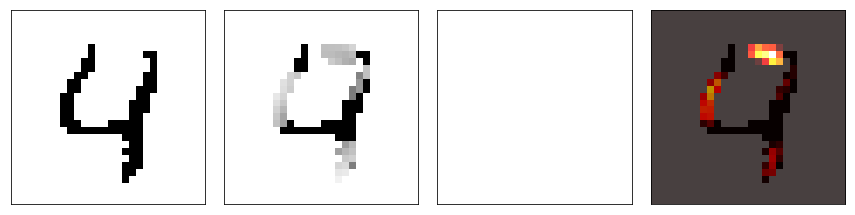

Max Luminescence (logit) = 208.45949
Total Luminescence (logit) = 3193.5098
Mean Luminescence (logit) = 4.0733542
Mean P(On) = 0.06279092
Depth = 1
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]


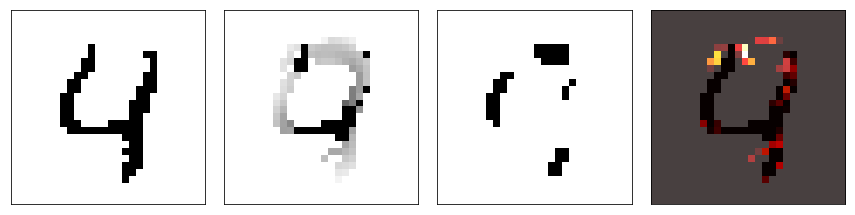

Max Luminescence (logit) = 152.42775
Total Luminescence (logit) = 5800.643
Mean Luminescence (logit) = 7.3987794
Mean P(On) = 0.10673267
Depth = 2
 - Predictions (scrambled) = [0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.43, 0.0, 0.08, 0.0]


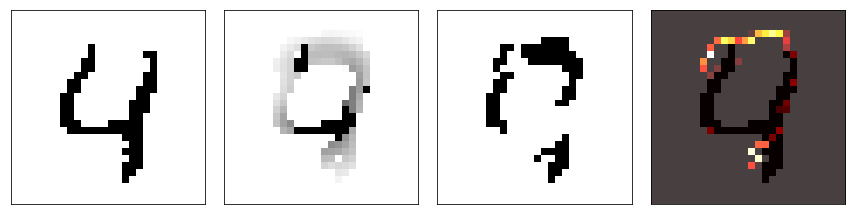

Max Luminescence (logit) = 114.817825
Total Luminescence (logit) = 9618.97
Mean Luminescence (logit) = 12.269094
Mean P(On) = 0.14566143
Depth = 3
 - Predictions (scrambled) = [0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


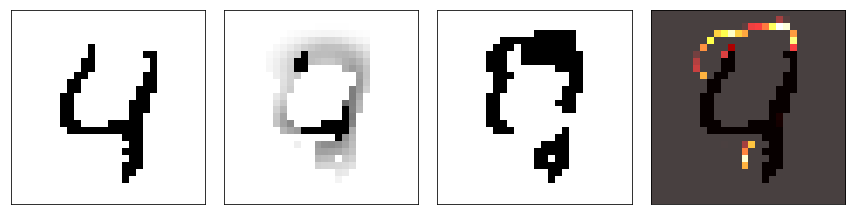

Max Luminescence (logit) = 114.822075
Total Luminescence (logit) = 13578.455
Mean Luminescence (logit) = 17.319458
Mean P(On) = 0.19193575


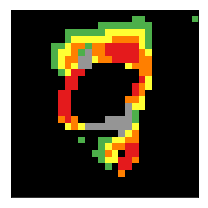

In [26]:
#Predict on test set

from numpy.ma import masked_array

save_figs = True

s_test = np.zeros((x_test.shape[0], 1))

test_ix = 1

n_levels = 4

drop_mask = np.zeros((batch_size, 28, 28, 1))

importance_score_qt_levels = [
    0.95,
    0.9,
    0.85,
    0.80
]

print("Test image " + str(test_ix) + ":")
    
y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[test_ix], axis=0)], batch_size=1)[0, 0]

print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])

importance_scores_levels = []
y_test_hat_levels = []

for level_ix in range(n_levels) :
    
    print("Depth = " + str(level_ix))
    
    _, image_test, sample_test, importance_scores_test = scrambler_model.predict_on_batch(x=[np.tile(np.expand_dims(x_test[test_ix], axis=0), (batch_size, 1, 1, 1)), np.tile(np.expand_dims(s_test[test_ix], axis=0), (batch_size, 1)), drop_mask])

    y_test_hat = predictor.predict(x=[sample_test[0]], batch_size=32)[:, 0].tolist()
    
    y_test_hat_levels.append(y_test_hat)
    
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat[:10]))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(image_test[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    #ax3.imshow(importance_scores_test[0, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')
    ax3.imshow(drop_mask[0, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')
    
    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[test_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    importance_scores_delta = np.copy(importance_scores_test)
    
    importance_scores_delta[drop_mask == 1] = 0.
    
    ax4.imshow(importance_scores_delta[0, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_delta[0, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(test_ix) + "_level_" + str(level_ix) + ".eps")
    
    plt.show()
    
    importance_thresh = np.quantile(np.ravel(importance_scores_test[0, :, :, 0]), q=importance_score_qt_levels[level_ix])
    
    importance_scores_delta_masked = np.copy(importance_scores_delta)
    importance_scores_delta_masked[importance_scores_delta_masked < importance_thresh] = 0.
    
    importance_scores_levels.append(importance_scores_delta_masked)
    
    max_lum = np.max(importance_scores_test[0, :, :, 0])
    total_lum = np.sum(importance_scores_test[0, :, :, 0])
    mean_lum = np.mean(importance_scores_test[0, :, :, 0])
    mean_p_on = np.mean(2. / (1. + np.exp(-importance_scores_test[0, :, :, 0])) - 1.)
    
    print("Max Luminescence (logit) = " + str(max_lum))
    print("Total Luminescence (logit) = " + str(total_lum))
    print("Mean Luminescence (logit) = " + str(mean_lum))
    print("Mean P(On) = " + str(mean_p_on))
    
    new_mask = np.array((importance_scores_test > importance_thresh), dtype=np.float)
    
    drop_mask = new_mask
    #drop_mask = 1. - new_mask


import numpy.ma as ma

f = plt.figure(figsize=(3, 3))

plt.imshow(1. - x_test[test_ix, :, :, 0], cmap="Greys", vmin=-1.0, vmax=1.0, aspect='equal')

cmap_vals = [
    0,
    4,
    5,
    2
]

for level_ix in range(n_levels) :
    
    importance_scores = importance_scores_levels[level_ix][0, :, :, 0]
    
    importance_scores_masked = ma.array(np.ones(importance_scores.shape), mask = importance_scores <= 0)
    
    plt.imshow(importance_scores_masked * cmap_vals[level_ix], alpha=1.0, cmap='Set1', vmin=0, vmax=8, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_test_example_" + str(test_ix) + "_levelset.eps")

plt.show()
